Algorithm B: Market Basket Analysis with Frequent Pattern Mining
1. Frequent Pattern Mining: Identify frequently purchased items or item sets using techniques like Apriori or FP-Growth.
2. Association Rule Mining: Generate association rules from frequent itemsets to understand purchase behavior.
3. Clustering with Gaussian Mixture Model (GMM): Use GMM to cluster customers based on their purchase patterns identified by the association rules

In [18]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


# Load the dataset
file_path = 'Train.csv'  # Update this if the file path changes
data = pd.read_csv(file_path)


c:\Users\1\anaconda3\envs\myenv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


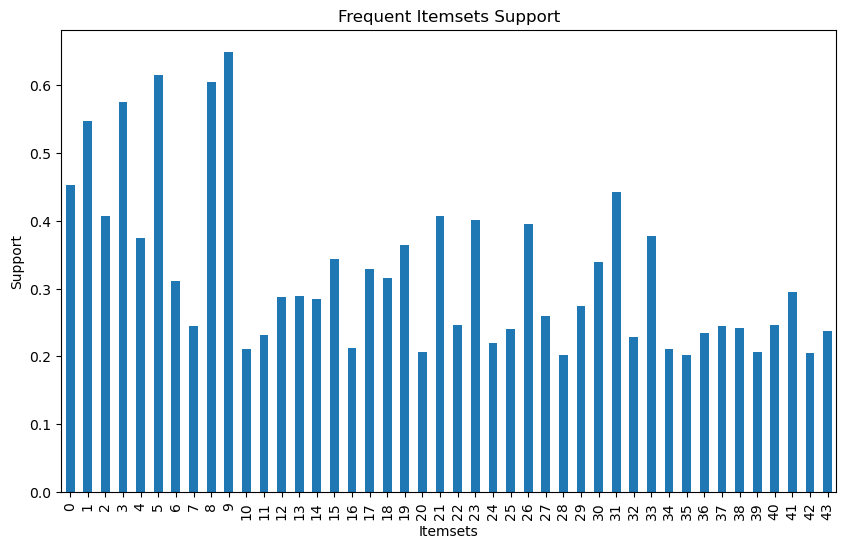

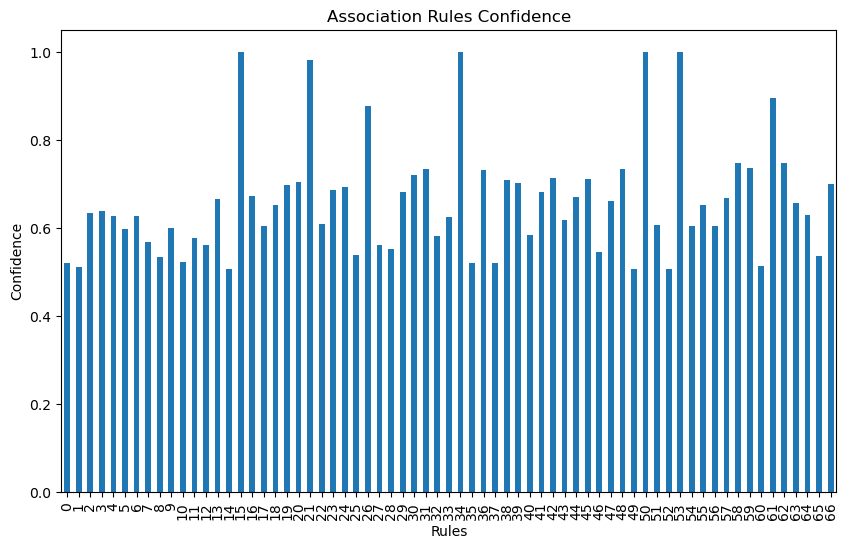

     support                                           itemsets  length  \
0   0.452529                                    (Gender_Female)       1   
1   0.547471                                      (Gender_Male)       1   
2   0.407164                                  (Ever_Married_No)       1   
3   0.575483                                 (Ever_Married_Yes)       1   
4   0.374566                                     (Graduated_No)       1   
5   0.615766                                    (Graduated_Yes)       1   
6   0.311849                                (Profession_Artist)       1   
7   0.244670                           (Spending_Score_Average)       1   
8   0.604611                               (Spending_Score_Low)       1   
9   0.649232                                      (Var_1_Cat_6)       1   
10  0.211577                   (Ever_Married_No, Gender_Female)       2   
11  0.231532                  (Gender_Female, Ever_Married_Yes)       2   
12  0.287060             

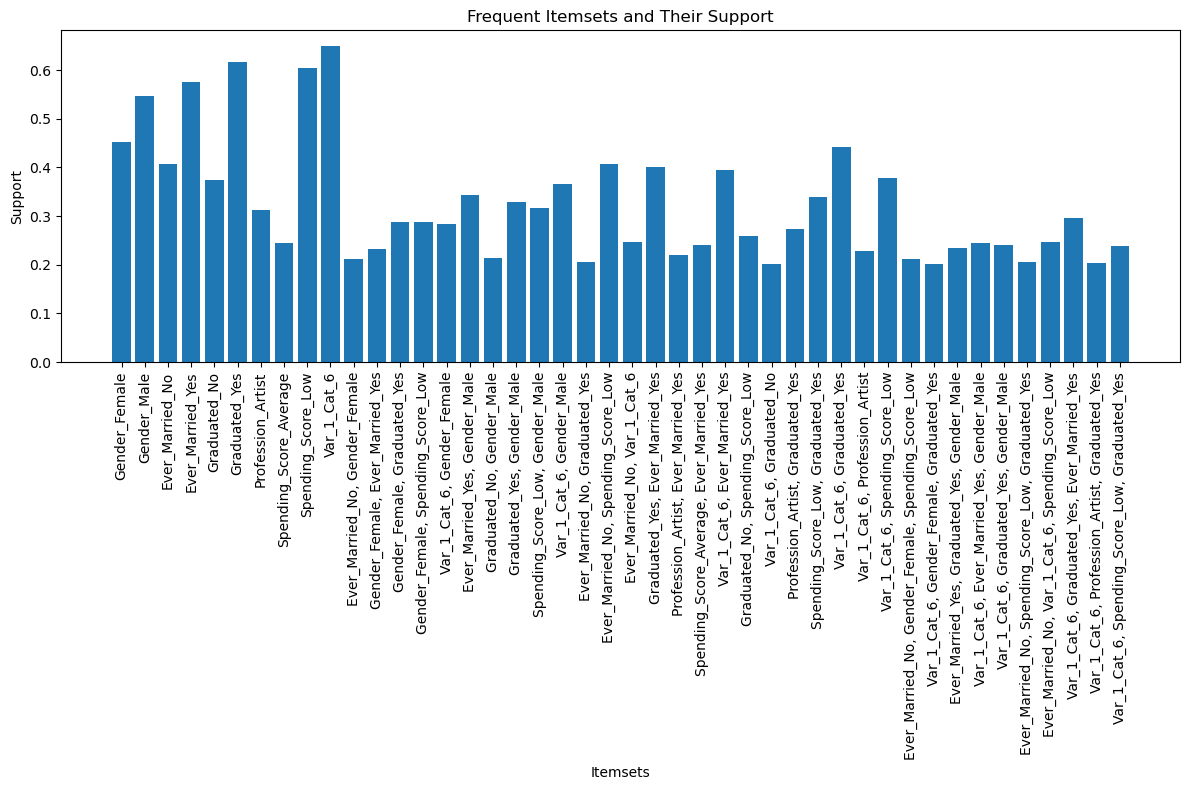

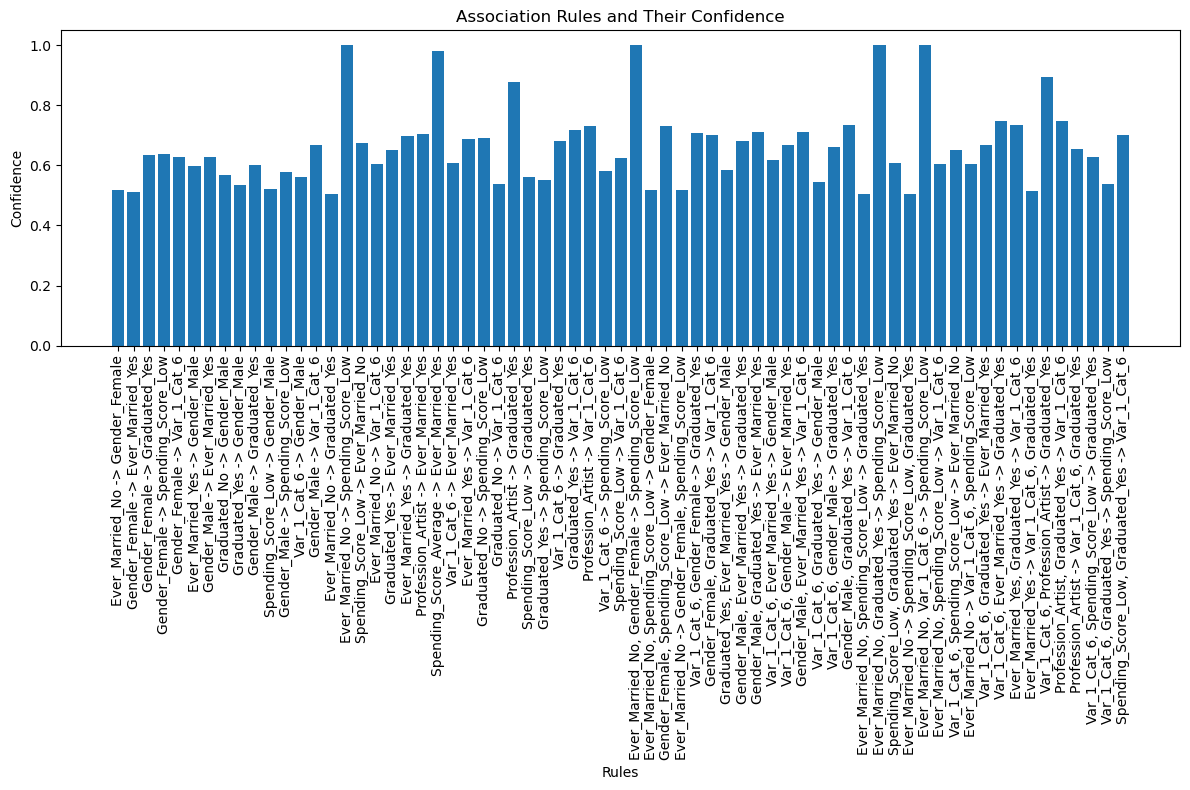

In [29]:
# Handling missing values
data.fillna({'Ever_Married': 'Unknown', 'Graduated': 'Unknown', 'Profession': 'Unknown', 'Var_1': 'Unknown'}, inplace=True)

# Selecting categorical columns for association rule mining
categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
categorical_data = data[categorical_cols]

# One-hot encoding for categorical data
onehot = OneHotEncoder()
categorical_data_encoded = onehot.fit_transform(categorical_data).toarray()

# Manually create feature names for one-hot encoded features
feature_names = []
for col, categories in zip(categorical_cols, onehot.categories_):
    for category in categories:
        feature_names.append(f'{col}_{category}')

# Create a DataFrame with the one-hot encoded features
categorical_data_encoded = pd.DataFrame(categorical_data_encoded, columns=feature_names)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(categorical_data_encoded, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Visualize Frequent Itemsets
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
plt.figure(figsize=(10, 6))
frequent_itemsets['support'].plot(kind='bar')
plt.ylabel('Support')
plt.xlabel('Itemsets')
plt.title('Frequent Itemsets Support')
plt.show()

# Visualize Association Rules
plt.figure(figsize=(10, 6))
rules['confidence'].plot(kind='bar')
plt.ylabel('Confidence')
plt.xlabel('Rules')
plt.title('Association Rules Confidence')
plt.show()

# Convert itemsets from frozenset to string for visualization
frequent_itemsets['itemsets_str'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

print(frequent_itemsets)

plt.figure(figsize=(12, 8))
plt.bar(frequent_itemsets['itemsets_str'], frequent_itemsets['support'])
plt.xticks(rotation=90)
plt.ylabel('Support')
plt.xlabel('Itemsets')
plt.title('Frequent Itemsets and Their Support')
plt.tight_layout()
plt.show()

# Creating a string representation of each rule
rules['rule'] = rules['antecedents'].apply(lambda x: ', '.join(list(x))) + " -> " + rules['consequents'].apply(lambda x: ', '.join(list(x)))

plt.figure(figsize=(12, 8))
plt.bar(rules['rule'], rules['confidence'])
plt.xticks(rotation=90)
plt.ylabel('Confidence')
plt.xlabel('Rules')
plt.title('Association Rules and Their Confidence')
plt.tight_layout()
plt.show()


C:\Users\1\AppData\Local\Temp\ipykernel_40984\512357899.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  categorical_data_for_encoding = data[['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']].applymap(str)


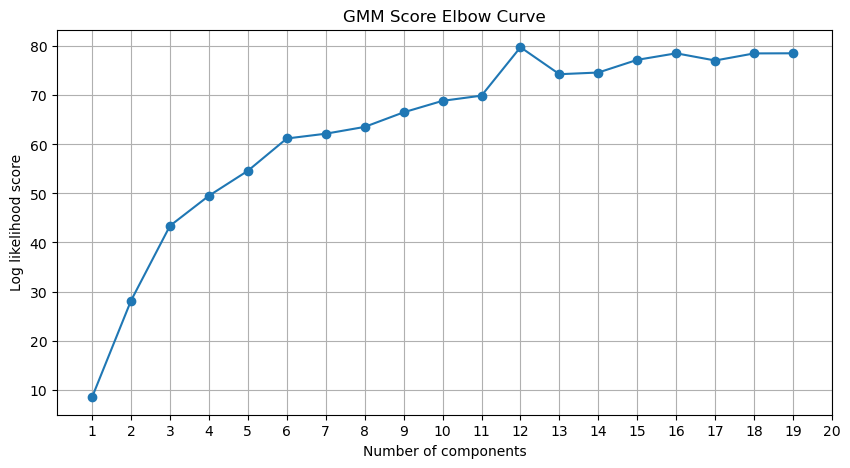

In [27]:
# Extracting relevant categorical columns based on the itemsets we have
categorical_data_for_encoding = data[['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']].applymap(str)

# Convert the DataFrame of categorical data into a list of lists for TransactionEncoder
transactions = categorical_data_for_encoding.values.tolist()

# Initialize TransactionEncoder
te = TransactionEncoder()

# Fit the TransactionEncoder on the transactions data
te_ary = te.fit(transactions).transform(transactions)

# Create a DataFrame from the encoded array
customer_itemset_matrix = pd.DataFrame(te_ary, columns=te.columns_)

# Combine the itemset matrix with numerical features for clustering
numerical_cols = ['Age', 'Work_Experience', 'Family_Size']
numerical_data = data[numerical_cols]

# Impute any remaining missing values in the numerical data
imputer = SimpleImputer(strategy='mean')
numerical_data_imputed = imputer.fit_transform(numerical_data)

# Scale the numerical data
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data_imputed)

# Combine the binary matrix with the scaled numerical data
combined_data = pd.concat([pd.DataFrame(numerical_data_scaled, columns=numerical_cols), customer_itemset_matrix], axis=1)

# Define the range of clusters to try
n_components_range = range(1, 20)
scores = []

# Calculate the scores for different number of components
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(combined_data)
    scores.append(gmm.score(combined_data))

# Plotting the elbow curve for the log likelihood (score)
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, scores, marker='o')
plt.xticks(range(1, 21, 1))
plt.title('GMM Score Elbow Curve')
plt.xlabel('Number of components')
plt.ylabel('Log likelihood score')
plt.grid(True)
plt.show()


In [28]:
# Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_components=12)
clusters = gmm.fit_predict(combined_data)

# Add the cluster labels to the original dataset
data['Cluster'] = clusters

# Silhouette Coefficient
silhouette = silhouette_score(combined_data, clusters)
print(f"Silhouette Coefficient: {silhouette}")

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(combined_data, clusters)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(combined_data, clusters)
print(f"Davies-Bouldin Index: {davies_bouldin}")


Cluster 0:
                   ID  Gender Ever_Married         Age Graduated Profession  \
count      133.000000     133          133  133.000000       133        133   
unique            NaN       2            3         NaN         3          8   
top               NaN  Female          Yes         NaN        No  Executive   
freq              NaN      76           56         NaN        71         32   
mean    463286.082707     NaN          NaN   40.278195       NaN        NaN   
std       2396.835224     NaN          NaN   14.914074       NaN        NaN   
min     459062.000000     NaN          NaN   18.000000       NaN        NaN   
25%     461006.000000     NaN          NaN   28.000000       NaN        NaN   
50%     462930.000000     NaN          NaN   39.000000       NaN        NaN   
75%     465348.000000     NaN          NaN   50.000000       NaN        NaN   
max     467817.000000     NaN          NaN   81.000000       NaN        NaN   

        Work_Experience Spending_Score 

Silhouette Coefficient: A measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 
  - The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Calinski-Harabasz Index: The ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters, where a higher score indicates better defined clusters.

Davies-Bouldin Index: A measure of how much better each object is described by its own cluster compared to other clusters. Lower values of the Davies-Bouldin Index indicate better clustering.